# Independent Components Analysis
## Eshed Margalit and Tucker Fisher
## August 2017

Like PCA (covered previously), the goal of ICA is to decompose a signal into meaningful components. While PCA aims to identify components which are orthogonal to each other and maximize explained variance, ICA aims to identify components which are statistically independent from one another (even if they're not orthogonal).

ICA sees a lot of use in audio processing (separating background noise from the statistically independent music), neuroimaging (separating independent contributions to a global signal), and EEG (separating statistically independent sources). 

In this notebook, we generate some dead simple (fake) EEG data, and attempt to recover the sources. Our setup is as follows: a number of sources are placed near a "brain" (either inside or outside). A number of electrodes are listening to the signals on the surface of the brain. Data is generated by recording a distance-weighted sum of sources on each electrode.

In [1]:
% add parent dir to path (gives access to utils)
addpath(genpath('..'))

In [2]:
n_sources = 2;
n_measurements = 2;
len = 50;
noise = 20;

[data, sources, source_coords, measurement_coords] = make_data(n_sources, len, noise, n_measurements);

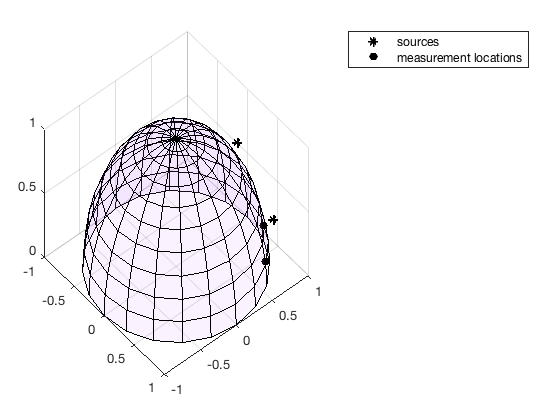

In [3]:
[ah] = visualize_signals(source_coords, measurement_coords);
azimuth = 50;
elevation = 50;
view(ah, [azimuth,elevation]) % rotate this with different az.+ el.

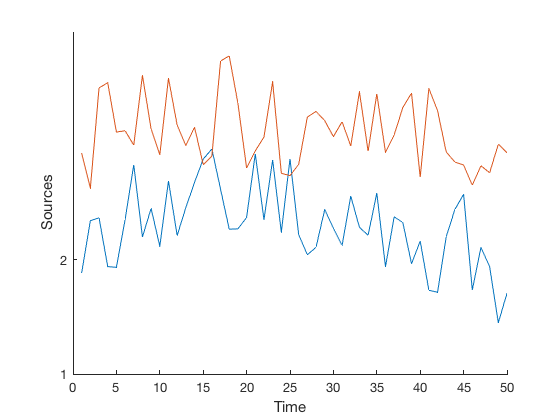

In [4]:
figure();
hold on;

for source = 1:n_sources
    source_timeseries = sources(source, :);
    plot(1:len, source_timeseries + source*noise);
end

xlabel('Time');
ylabel('Sources');
yticks(linspace(noise,noise*n_sources,n_sources));
yticklabels(1:n_sources);

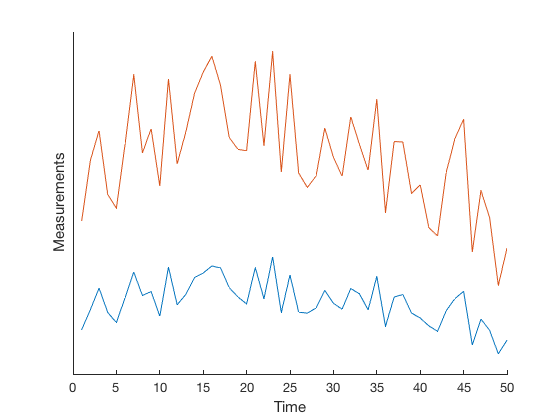

In [5]:
figure();
hold on;

for measurement = 1:n_measurements
    measurement_timeseries = data(measurement, :);
    plot(1:len, measurement_timeseries + measurement*noise);
end

xlabel('Time');
ylabel('Measurements');
yticks(linspace(noise,noise*n_measurements,n_measurements));
yticklabels(1:n_measurements);

Before proceeding, we convert the data into the notation from the Shlens paper. With few exceptions, the rest of the code in this notebook follows that example closely.

In [6]:
x = data;
[d, n] = size(x);

# ICA - It's all about building W
Remember from **SVD**:  $\mathbf{A = U \Sigma V^T}$.
That is, we can decompose any arbitrary matrix, $\mathbf{A}$, into a rotation matrix, a diagonal matrix, and another rotation matrix. This will be useful because we want to get $\mathbf{x = As}$ to $\mathbf{\hat{s} = W x}$. Thus, we need the inverse of $\mathbf{W}$.

$\mathbf{W = A^{-1}}$ and $\mathbf{\hat{s} \approx s}$

Thanks to **SVD**, taking the inverse of $\mathbf{A}$ is as simple as taking the transpose of $\mathbf{U \Sigma V^T}$ (i.e., $\mathbf{(U \Sigma V^T)^T}$) as long as we assume the $\mathbf{s}$ (sources) are whitened, which means that the sources are decorellated:
$$\mathbf{\langle ss^T \rangle = cov(s) = C_s} =
          \left[ {\begin{array}{cccc}
           1 & 0 & 0 \\
           0 & 1 & 0 \\
           0 & 0 & 1 \\
\end{array} } \right] $$

This makes $\mathbf{W = (U \Sigma V^T)^T = V \Sigma^{-1} U^T}$. 

<img src="img/Shlens_says_it_best.png">

*from [Shlens, 2014](https://arxiv.org/abs/1404.2986)*

Remember 

$$\mathbf{\Sigma} =
          \left[ {\begin{array}{cccc}
           \sqrt{\lambda_1} & 0 & 0 \\
           0 & \sqrt{\lambda_2} & 0 \\
           0 & 0 & \sqrt{\lambda_3} \\
\end{array} } \right] = 
           \left[ {\begin{array}{cccc}
           var_{1,1} & 0 & 0 \\
           0 & var_{2,2} & 0 \\
           0 & 0 & var_{3,3} \\
\end{array} } \right] $$

so...

to get from $\mathbf{\Sigma^2 = D => \Sigma}$ we must $\mathbf{D^{-1/2}}$ now we have arrived at

$$\mathbf{W = VD^{-1/2}E^T}$$

$\mathbf{D^{-1/2}}$ and $\mathbf{E^T}$ perform an operation called whitening.

Whitening decorrelates (in other words makes covariance matrix 1s on the diagonal and zeros everywhere else) and then normalizes (shrinks the variance along each dimension so that they all are the same)

With that blurb in mind take a look at this figure:

<img src="img/Shlens_whitening.png">

*from [Shlens, 2014](https://arxiv.org/abs/1404.2986)*


By preceding explanations, ICA reduces to estimating sources such that
$$
\hat{s} = Vx_{w}
$$
, where $V$ is a rotation matrix. Let's start by preparing the whitened data:

In [7]:
% mean subtraction
x = x - repmat(mean(x,2), 1, n);

In [8]:
[E, D] = eig(cov(x'));

In [9]:
x_w = sqrtm(pinv(D))*E'*x;

# Finding the rotation matrix
The goal is to identify the right $V$, such that sources have minimal pairwise mutual information (multi-information). There is no analytical solution to this problem, so we are left with a number of numerical estimates to choose from. Below, we proceed with the solution proposed in [Shlens 2014](https://arxiv.org/abs/1404.2986): the FOBI (Fourth Order Blind Identification) algorithm.

#### FOBI
As described in the Shlens paper, the FOBI optimization relates to finding the directions in the data which maximize fourth-order correlations. It essentially finds the eigenvectors of what is known as the quadricovariance matrix.

Quadricovariance is beyond the scope of this tutorial, but you can consider it a representation of fourth-order correlations. It serves as an approximation of the multi-information. Eigendecomposition of this matrix finds the directions which maximize variance in the fourth-order correlations.

In [10]:
quadricov = (repmat(sum(x_w.*x_w,1),d,1).*x_w)*x_w';
[V,s,u] = svd(quadricov);

In [11]:
W = V * sqrtm(pinv(D)) * E';

In [12]:
S = W * x;

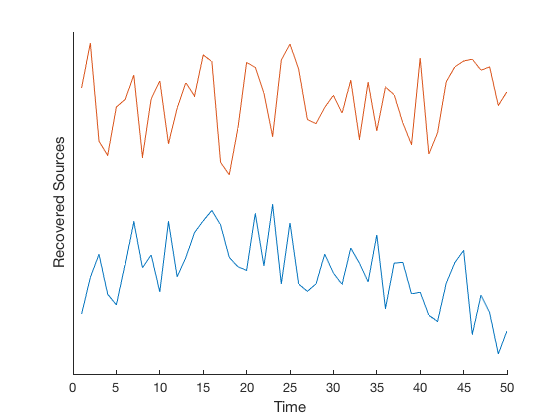

In [13]:
figure();
hold on;

for measurement = 1:n_measurements
    measurement_timeseries = S(measurement, :);
    plot(1:len, measurement_timeseries + measurement*noise/4);
end

xlabel('Time');
ylabel('Recovered Sources');
yticks(linspace(noise,noise*n_measurements,n_measurements));
yticklabels(1:n_measurements);

Okay, now let's look at our original (hidden) sources again.

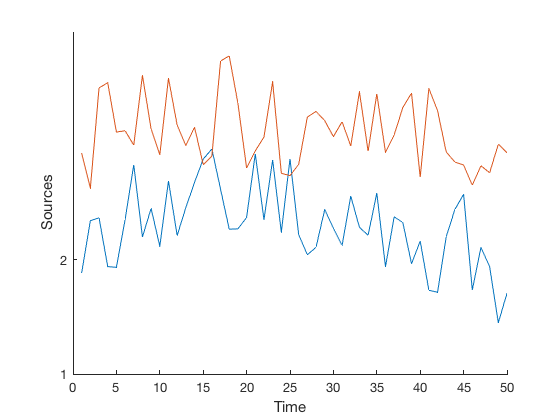

In [14]:
figure();
hold on;

for source = 1:n_sources
    source_timeseries = sources(source, :);
    plot(1:len, source_timeseries + source*noise);
end

xlabel('Time');
ylabel('Sources');
yticks(linspace(noise,noise*n_sources,n_sources));
yticklabels(1:n_sources);

Did our implementation do a good job? Maybe, but it's actually really hard to tell. That's partially because the independent components can be flipped or inverted and still be 'correct'. Alas, comparison by eye is the easiest way to determine. Since the data generation is non-deterministic, I have no comment about the above outputs-- it's up to you to decide how good the recovery was!